# Hand digit classifier 
---
## Incremental network quantization

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from skimage import io

### Importing MNIST dataset

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_data = torchvision.datasets.MNIST(root='../', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root="../", train=False, download=True, transform=transform)

train_set = [train_data[i] for i in range(50000)]
validation_set = [train_data[i] for i in range(50000, 60000)]

### Setting up data loaders

In [3]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

### Definig a VGG-7 inspired architecture model
---
Featuring 4 convolutional and 3 fully connected layers

In [4]:
class VGG7(nn.Module):
    def __init__(self):
        super(VGG7, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding="same", stride=1, bias=False)
        self.conv2 = nn.Conv2d(64, 64, 3, padding="same", stride=1, bias=False)
        self.conv3 = nn.Conv2d(64, 128, 3, padding="same", stride=1, bias=False)
        self.conv4 = nn.Conv2d(128, 128, 3, padding="same", stride=1, bias=False)
        
        self.fc1 = nn.Linear(7*7*128, 512, bias=False)
        self.fc2 = nn.Linear(512, 256, bias=False)
        self.fc3 = nn.Linear(256, 10, bias=False)

    def forward(self, x): 
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, stride=2)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, stride=2)  

        x = x.view(-1, 7*7*128)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)  

        x = F.log_softmax(x, dim=1)  

        return x

### Shift Quantization operations

In [5]:
def getBounderyExponents(W, b):
    s = torch.max(torch.abs(W)).item()
    n1 = np.floor(np.log2(4*(s/3)))
    n2 = n1 + 1 - (2**(b - 1))/2
    return n1, n2

def getQuantizationMask(W, percentage, T):
    w = W.view(-1)
    t = T.view(-1)
    idx = t == 1

    numberOfWeights = w.size(dim=0)
    numberOfQWeights = int(percentage*numberOfWeights - t[idx].size(dim=0))

    t_aux = torch.Tensor(np.ones_like(T)).view(-1)
    w = w*(t_aux - t)
    w = torch.abs(w)
    sorted_w, indices_w = w.sort()
    t[indices_w[-numberOfQWeights:]] = 1
    
    return t.view(T.size())

def quantizeWeights(W, T, n1, n2):
    T_aux = torch.Tensor(np.ones_like(T))
    eps = 1e-6
    W1 = W*(T_aux - T)
    idx = W == 0
    W.data[idx] = eps

    closestExp = torch.floor(torch.log2(torch.abs(W*4/3)))
    Q = W1 + torch.sign(W)*(2**closestExp)*T

    idx = closestExp*T < n2
    Q[idx] = 0
    idx = closestExp*T > n1
    Q[idx] = 2**n1

    return closestExp, Q

def quantize_conv_layer(W, T, percentage):
    n = T.size(dim=0)
    m = T.size(dim=1)

    for i in range(n):
        for j in range(m):
            T[i, j, :, :] = getQuantizationMask(W[i, j, :, :], percentage, T[i, j, :, :])
            _, W.data[i, j, :, :] = quantizeWeights(W[i, j, :, :], T[i, j, :, :], 2, -3)

In [6]:
W = torch.tensor(np.array([
    [0.01, 0.02, -0.2, 0.04, 0.33],
    [0.17, -0.42, -0.33, 0.02, -0.05], 
    [0.02, 0.83, -0.03, 0.03, 0.06],
    [-0.9, 0.07, 0.11, 0.87, -0.36], 
    [-0.73, 0.41, 0.42, 0.39, 0.47]]))
bit_length = 4
n1, n2 = getBounderyExponents(W, bit_length)
print(n1, n2)
T = torch.Tensor(np.zeros_like(W))
T = getQuantizationMask(W, 0.5, T)
print(T)
_, W = quantizeWeights(W, T, n1, n2)

W = torch.Tensor(np.array([
    [0.11, 0.04, -0.7, 0.19, -0.25],
    [0.15, -0.5, -0.25, -0.09, -0.02],
    [-0.02, 1, -0.06, 0.21, 0.15],
    [-1, 0.27, -0.09, 1, -0.25],
    [-0.5, 0.5, 0.5, 0.5, 0.5]
]))

T = getQuantizationMask(W, 0.75, T)
_, W = quantizeWeights(W, T, n1, n2)
print(T)
print(W)

0.0 -3.0
tensor([[0., 0., 0., 0., 1.],
        [0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1.]])
tensor([[0., 0., 1., 1., 1.],
        [1., 1., 1., 0., 0.],
        [0., 1., 0., 1., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1.]])
tensor([[ 0.1100,  0.0400, -0.5000,  0.2500, -0.2500],
        [ 0.1250, -0.5000, -0.2500, -0.0900, -0.0200],
        [-0.0200,  1.0000, -0.0600,  0.2500,  0.1250],
        [-1.0000,  0.2500, -0.0900,  1.0000, -0.2500],
        [-0.5000,  0.5000,  0.5000,  0.5000,  0.5000]])


### Device initialization for training

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
net = torch.load("../Baseline/baseline.pth")
net.to(device)

optimizer = optim.SGD(net.parameters(), lr = 1e-2, weight_decay=0)

quantization_percentages = [0.5, 0.75, 0.875]

epochs = 5
logs_interval = 100
iteration = 0
train_loss = []

Tconv1 = torch.zeros_like(net.conv1.weight)
Tconv2 = torch.zeros_like(net.conv2.weight)
Tconv3 = torch.zeros_like(net.conv3.weight)
Tconv4 = torch.zeros_like(net.conv4.weight)

net.train()

for percentage in quantization_percentages:
    # quantize layers
    quantize_conv_layer(net.conv1.weight, Tconv1, percentage)
    quantize_conv_layer(net.conv2.weight, Tconv2, percentage)
    quantize_conv_layer(net.conv3.weight, Tconv3, percentage)
    quantize_conv_layer(net.conv4.weight, Tconv4, percentage)
    
    # correct remaining weights by training
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = F.nll_loss(output, target)
            loss.backward()

            # setam gradienti la 0
            Tconv1_aux = torch.ones_like(Tconv1)
            Tconv2_aux = torch.ones_like(Tconv2)
            Tconv3_aux = torch.ones_like(Tconv3)
            Tconv4_aux = torch.ones_like(Tconv4)
            net.conv1.weight.grad = net.conv1.weight.grad*(Tconv1_aux - Tconv1)
            net.conv2.weight.grad = net.conv2.weight.grad*(Tconv2_aux - Tconv2)
            net.conv3.weight.grad = net.conv3.weight.grad*(Tconv3_aux - Tconv3)
            net.conv4.weight.grad = net.conv4.weight.grad*(Tconv4_aux - Tconv4)

            optimizer.step()

            iteration = iteration + 1
            if iteration % logs_interval == 0:
                print('Train epoch:{}, batch index:{}, loss:{}'.format(epoch, batch_idx, loss.item()/logs_interval))
                train_loss.append(loss.item())    

quantize_conv_layer(net.conv1.weight, Tconv1, 1)
quantize_conv_layer(net.conv2.weight, Tconv2, 1)
quantize_conv_layer(net.conv3.weight, Tconv3, 1)
quantize_conv_layer(net.conv4.weight, Tconv4, 1)                

Train epoch:0, batch index:99, loss:0.00455804169178009
Train epoch:0, batch index:199, loss:0.0025925412774086
Train epoch:0, batch index:299, loss:0.0014620889723300935
Train epoch:0, batch index:399, loss:0.001969074010848999
Train epoch:0, batch index:499, loss:0.0012720736861228943
Train epoch:0, batch index:599, loss:0.0017360101640224457
Train epoch:0, batch index:699, loss:0.0021210417151451113
Train epoch:1, batch index:17, loss:0.0028522840142250062
Train epoch:1, batch index:117, loss:0.001281285732984543
Train epoch:1, batch index:217, loss:0.001065356656908989
Train epoch:1, batch index:317, loss:0.0007526491582393646
Train epoch:1, batch index:417, loss:0.002630416452884674
Train epoch:1, batch index:517, loss:0.0004044533148407936
Train epoch:1, batch index:617, loss:0.00035694867372512815
Train epoch:1, batch index:717, loss:0.00017478382214903833
Train epoch:2, batch index:35, loss:0.0008840052038431167
Train epoch:2, batch index:135, loss:0.0008369332551956177
Train e

Test set average loss: 1.381783313179016, accuracy: 45.57%


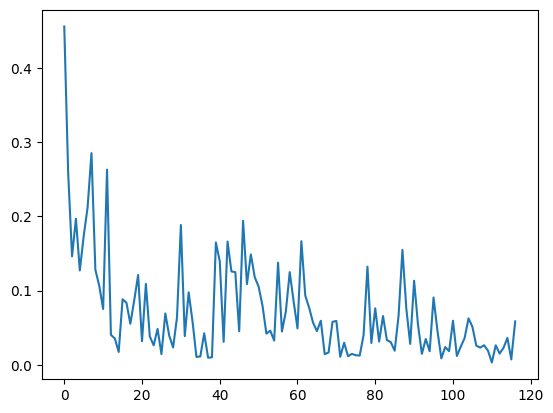

In [14]:
net.eval()
loss = 0
correct = 0

confusion_matrix = np.zeros((10, 10))

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss += F.nll_loss(output, target, reduction="sum").item()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        confusion_matrix[pred.cpu()[:, 0], target.cpu()] += 1

    loss = loss/len(test_loader.dataset)
    accuracy = 100.*correct/len(test_loader.dataset)
    print('Test set average loss: {}, accuracy: {}%'.format(loss, accuracy))

plt.plot(train_loss)

In [16]:
# net = VGG7()
# net.to(device)

# optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=0)
# wei = torch.clone(net.conv1.weight)
# Tconv1 = torch.zeros_like(net.conv1.weight)
# quantize_conv_layer(net.conv1.weight, Tconv1, 0.5)
# wei_q = torch.clone(net.conv1.weight)

# net.train()

# sample, lable = train_data[0]
# lable = torch.Tensor([lable]).long()
# optimizer.zero_grad()
# output = net(sample)
# loss = F.nll_loss(output, lable)
# loss.backward()

# Tconv1_aux = torch.ones_like(Tconv1)
# net.conv1.weight.grad = net.conv1.weight.grad*(Tconv1_aux - Tconv1)
# optimizer.step()


# print(wei[0, 0, :, :])
# print(Tconv1[0, 0, :, :])
# print(wei_q[0, 0, :, :])
# print(net.conv1.weight[0, 0, :, :])


Parameter containing:
tensor([[[[ 0.2500,  0.1250,  0.1250],
          [ 0.5000,  0.0000,  0.2500],
          [ 0.1250,  0.2500,  0.2500]]],


        [[[ 0.0000, -0.1250,  0.0000],
          [ 0.0000,  0.2500,  0.2500],
          [-0.1250,  0.0000, -0.2500]]],


        [[[-0.1250,  0.0000,  0.0000],
          [ 0.1250,  0.0000, -0.1250],
          [-0.2500, -0.1250,  0.0000]]],


        [[[ 0.1250, -0.1250,  0.2500],
          [-0.2500,  0.2500,  0.1250],
          [ 0.1250, -0.1250, -0.1250]]],


        [[[-0.1250,  0.0000,  0.0000],
          [ 0.0000, -0.2500, -0.2500],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[ 0.0000, -0.2500, -0.1250],
          [ 0.2500,  0.0000, -0.2500],
          [-0.1250,  0.0000,  0.1250]]],


        [[[ 0.0000,  0.0000,  0.2500],
          [ 0.2500,  0.2500,  0.2500],
          [ 0.2500,  0.2500,  0.0000]]],


        [[[ 0.2500,  0.2500,  0.2500],
          [ 0.2500,  0.2500,  0.5000],
          [ 0.2500,  0.5000,  0.5000]]],


        [[